In [1]:
import igraph as ig
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import zip_longest
from itertools import islice
from tqdm import tqdm
import os
from random import sample

# Degree Analysis

Compare degree distributions & other degree-based stats over updates

## Degree distributions

Comparisons of degree distributions across updates

In [4]:
def degree_dist_plot(degrees):
    plt.plot(degrees, color="#fdc799", alpha=0.8) #, np.arange(0,len(degrees),1))
    plt.loglog()

In [11]:
#Quarterly update strings
test = ["20150401", "20150701"]
updates = [
        "20150401", "20150701", "20151001", "20160101", "20160401", "20160701",
        "20161001", "20170101", "20170401", "20170701", "20171001", "20180101",
        "20180401", "20180701", "20181001", "20190101", "20190401", "20190701",
        "20191001", "20200101", "20200401", "20200701", "20201001", "20210101"
    ]

#Load all degrees associated with quarterly updates
all_degrees = []
for f in tqdm(os.listdir("Data/Degrees/")):
    if f.startswith("degrees_"):
        degrees = pickle.load(file=open("Data/Degrees/" + f, "rb"))
        degrees.sort(reverse=True)
        all_degrees.append(degrees)
print(len(all_degrees))

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:59<00:00,  2.13it/s]

63


In [13]:
#Calculate & plot average of all degrees (avg over each column)
#Note: takes ~20 minutes
avg = [np.ma.average(np.ma.masked_values(temp_list,None)) for temp_list in tqdm(zip_longest(*all_degrees))]

14076090it [19:15, 12182.52it/s]


MemoryError: 

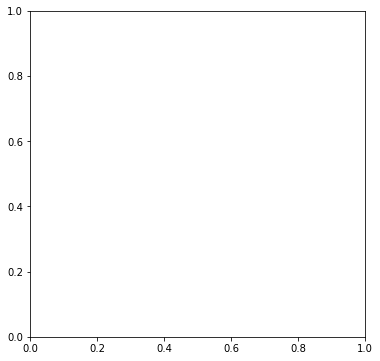

In [17]:
#Plot degree distribution comparisons
plt.figure(figsize=(6,6))

#Quarterly update
for degrees in sample(all_degrees, 10):
    degree_dist_plot(degrees)

#Average over all degrees
#avg.sort(reverse=True)
plt.plot(avg, color="#aa0f35", linewidth=5.0, label="Average Degree")

plt.xlabel("Sorted Degree order (log)")
plt.ylabel("Degree (log)")

#Add legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color="#fdc799", label="Updates"))
plt.legend(handles=handles)


## Attachment 

Calculate attachment over quarterly updates (see Rednar 2004 as a guide)

### Preferential Attachment calculations

Set up & perform preferential attachment calculations

In [ ]:
#Test on two linked updates
test = ["20150401", "20150701"]

updates = [
        "20150401", "20150701", "20151001", "20160101", "20160401", "20160701",
        "20161001", "20170101", "20170401", "20170701", "20171001", "20180101",
        "20180401", "20180701", "20181001", "20190101", "20190401", "20190701",
        "20191001", "20200101", "20200401", "20200701", "20201001", "20210101"
    ]

# TODO Define dictionary - will be [id: [list of degrees of len(updates)]]
full_id_degrees = {}
size = 63 #there are 63 unique update files

i = 0
for f in tqdm(os.listdir("Data/Degrees/")):
    if f.startswith("id_degrees_"):
        #Load id_degree dictionary
        id_degrees = pickle.load(file=open("Data/Degrees/" + f, "rb"))

        # TODO Add / update to full dictionary. 

        for key, value in id_degrees.items():
            #If a id is in the dictionary, update the appropriate degree value
            if key in full_id_degrees:
                full_id_degrees[key][i] = sum(full_id_degrees[key]) + value
            # If a id is not in the dictionary, add it with a list of len(updates) 0s and update the appropriate degree value
            else:
                full_id_degrees[key] = [0]*size
                full_id_degrees[key][i] = value
        i += 1

print(list(islice(full_id_degrees.items(), 10)))

    

 92%|██████████████████████████████████████████████████████████████████████▉      | 116/126 [1:33:43<41:40, 250.06s/it]

In [5]:
#Replace all zero values with the last non-zero value
for key, value in tqdm(full_id_degrees.items()):
    arr = np.array(value)
    prev = np.arange(len(arr))
    prev[arr == 0] = 0
    prev = np.maximum.accumulate(prev)
    full_id_degrees[key] = arr[prev]

100%|██████████| 8951018/8951018 [01:13<00:00, 122337.46it/s]


In [11]:
#Calculate preferential attachment
pref_attach_dict = {}

for key, value in tqdm(full_id_degrees.items()):
    c = 0
    attachments = []
    while c < len(value) - 1:
        attachments.append(value[c+1] - value[c])
        c += 1
    pref_attach_dict[key] = np.mean(attachments)

100%|██████████| 8951018/8951018 [04:05<00:00, 36450.04it/s]


### Preferential Attachment graphing

Initially inspired by Redner (2004) - citations on x axis, attachment rate on y axis

In [2]:
#Read in pickled files 
full_id_degrees = pickle.load(file=open("Z:/group/John Malloy/Projects/Patents/Data/full_id_degrees_1980_1989.p", "rb"))
pref_attach_dict = pickle.load(file=open("Z:/group/John Malloy/Projects/Patents/Data/pref_attach_dict_1980_1989.p", "rb"))

In [9]:
#Create two list of initial degrees
initial_degrees = []
for key, value in full_id_degrees.items():
    initial_degrees.append(value[0])
    
#fit a line of best fit
m, b = np.polyfit(initial_degrees, list(pref_attach_dict.values()), 1)
print(m,b)

1.1980340412618093 2.451496235811739


Text(0.5, 1.0, 'Preferential Attachement: 1980 - 1990')

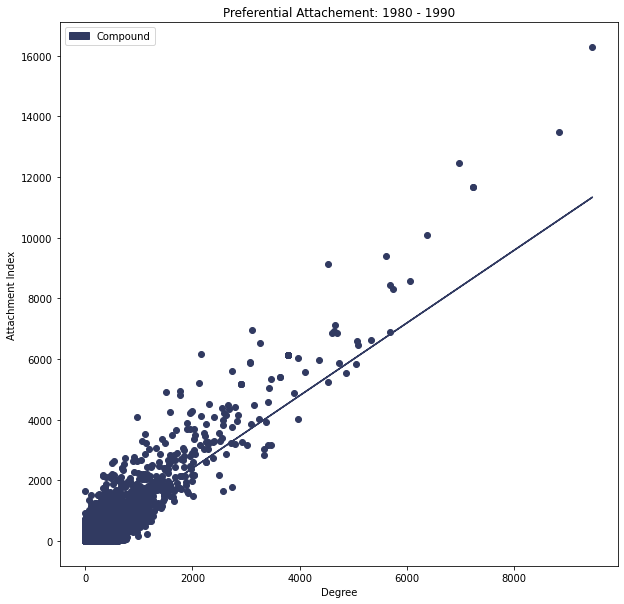

In [10]:
plt.figure(figsize=(10,10))

plt.scatter(x=initial_degrees, y=pref_attach_dict.values(), color="#313a61")
plt.plot(initial_degrees, m*np.array(initial_degrees) + b, color="#313a61")

plt.xlabel("Degree")
plt.ylabel("Attachment Index")

#Add legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color="#313a61", label="Compound"))
plt.legend(handles=handles, loc="upper left")
plt.title("Preferential Attachement: 1980 - 1990")

# Connectivity analysis

_Question:_ Does connectivity increase over time within SureChemBL? 

_Hypothesis:_ patents become more connective over time, thereby using more of the same chemical space over time

## Bipartite stats

Use basic statistics (number of nodes & edges of both cpds & patents) from bipartite network analysis to test percent connectivity

In [2]:
df = pd.read_csv("Data/Graphs/bipartite_sizes.csv")
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'Data/Graphs/bipartite_sizes.csv'

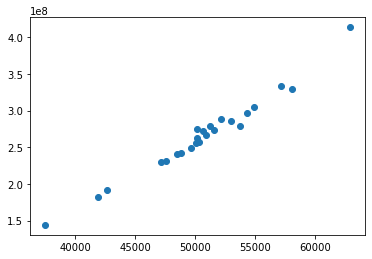

In [13]:
#Does patent nodes scale with patent edges?
plt.scatter(x=df["patent_nodes"], y=df["patent_edges"])

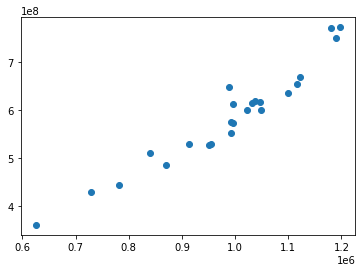

In [14]:
#How about compounds?
plt.scatter(x=df["cpd_nodes"], y=df["cpd_edges"])

In [6]:
#Test graph analysis
G = pickle.load(file=open("Data/Graphs/G_20210101.p", "rb"))
print(ig.summary(G))

IGRAPH UN-T 1162328 4555905 -- 
+ attr: date (v), name (v), type (v)
None
